## Exercise 10: Image stitching

Today’s exercise is different from the previous weeks in that it has only a few exercises followed by multiple options for how to improve your algorithm. You are going to implement an algorithm that can stitch at least two images together, by using RANSAC to estimate a homography.

Start out with using `im1` and `im2`.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

- **Exercise 10.1**. Find SIFT keypoints`(kp1, kp2)` in both images and compute their descriptors `(des1, des2)`. Match the SIFT features from both images to each other.



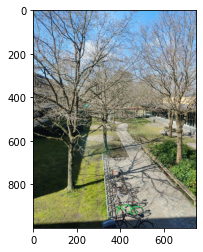

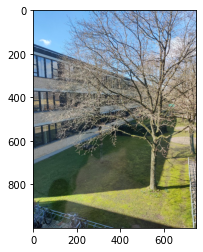

In [2]:
img1 = plt.imread("im1.jpg")
img2 = plt.imread("im2.jpg")

plt.imshow(img1)
plt.show()

plt.imshow(img2)
plt.show()

Number of matches: 8424


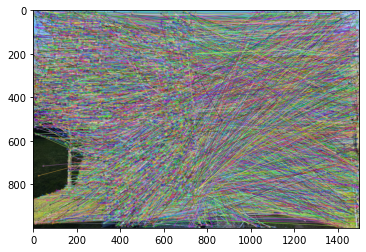

In [3]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.match(des1,des2)
     
print('Number of matches:',len(matches))

matched_img = cv2.drawMatches(img1, kp1, img2, kp2, matches, img2,flags=2)

plt.imshow(matched_img)
plt.show()


In [4]:
#We take the coordiantes of 4 random matches:
list_p1=[]
list_p2=[]

for mat in matches:
    # Get the matching keypoints for each of the images
    img1_idx = mat.queryIdx
    img2_idx = mat.trainIdx
    
    # Get the coordinates
    (x1, y1) = kp1[img1_idx].pt
    (x2, y2) = kp2[img2_idx].pt
    
    # Append to each list
    list_p1.append((x1, y1))
    list_p2.append((x2, y2))

print(len(list_p1))
print(len(list_p2))

8424
8424


- **Exercise 10.2**. Implement a RANSAC algorithm for finding the homography between `im1` and `im2`.
    What is the minimum number of matches you need to estimate a homography? (Tip: it’s four)
    Explain why this is the case.
    
    Use Equation (2.45) from the lecture notes to compute the distance of a match to a homography.
    
    Assume $σ = 3$ and use the formulas from the lecture last week to determine the threshold for when a match should be considered an inlier.

    While best practice would be to determine the number of iterations while running the algorithm, you can fix it to i.e. 200.
    
    To verify that the inliers of the best model are reasonable, visualize them. Consider using the following code:
    `plt.imshow(cv2.drawMatches(im1, kp1, im2, kp2, np.array(matches)[bestInliers], None))`

    On the provided images you should find in the ballpark of a thousand inliers.



In [5]:
def hest(p,q):
    B=np.zeros((1,9))
    for i in range(len(p)):
        x1=p[i][0]
        y1=p[i][1]
        x2=q[i][0]
        y2=q[i][1]
        B_i=np.array([[0,-x2,x2*y1,0,-y2,y1*y2,0,-1,y1],[x2,0,-x2*x1,y2,0,-y2*x1,1,0,-x1],
                      [-x2*y1,x2*x1,0,-y2*y1,y2*x1,0,-y1,x1,0]])
        
        B=np.vstack([B, B_i])
    
    B=B[1:,:] #12x9
    

    #The solution of Ax=0 is found using SVD, where the singular vector v corresponds to 
    #the smallest singular value.
    #OUTPUT: s=singular values, 
    
    u,s,vh= np.linalg.svd(B,full_matrices=True, compute_uv=True)
    #u: 12x12, s:9(vector with singular values), vh: 9x9

    H=H=vh[8,:]
    H_est=H.reshape((3,3),order='F')
    
    
    H_norm=((H_est/H[8])*3).reshape((3,3),order='F')
    
    return H_est, H_norm


In [14]:
def select_points(matches,n):
    p1_sel=[]
    p2_sel=[]
    
    ran_mat=np.random.choice(matches, n, replace=False)
    
    for sel in ran_mat:
        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # Get the coordinates
        (x1, y1) = kp1[img1_idx].pt
        (x2, y2) = kp2[img2_idx].pt

        # Append to each list
        p1_sel.append((x1, y1))
        p2_sel.append((x2, y2))
    
    return p1_sel,p2_sel

In [16]:
#First, we take 4 random points from the list of coordinates:
import random
s_p1,sp2=select_points(matches,4)

H_esti,H_norm=hest(s_p1,s_p2) 

print('H estimation:')
print(H_esti)
print(" ")
print('H estimation normalized:')
print(np.round(H_norm))

H estimation:
[[ 1.90359090e-01  6.11574135e-01 -7.68666156e-02]
 [ 2.25466988e-01  7.24366662e-01 -9.10431141e-02]
 [ 2.54770037e-04  8.18509718e-04 -1.02875626e-04]]
 
H estimation normalized:
[[-5.5510e+03 -1.7834e+04  2.2420e+03]
 [-6.5750e+03 -2.1124e+04  2.6550e+03]
 [-7.0000e+00 -2.4000e+01  3.0000e+00]]


In [80]:
def distance_match_homo(H,p1,p2):
    b=H@p2
    binv=np.linalg.inv(H)@p1
    
    in_Hp2=np.array([b[0]/b[2],b[1]/b[2]])
    in_Hinvp1=np.array([binv[0]/binv[2],binv[1]/binv[2]])
    in_p1=np.array([p1[0]/p1[2],p1[1]/p1[2]])
    in_p2=np.array([p2[0]/p2[2],p2[1]/p2[2]])
    
    dif1=in_Hp2-in_p1
    dif2=in_Hinvp1-in_p2
    
    a1=np.sqrt(dif1[0]**2+dif1[1]**2)
    a2=np.sqrt(dif2[0]**2+dif2[1]**2)
    dist=a1+a2

    return dist

In [83]:
#Example distance of a match to an homogrpahy:
p1,p2=select_points(matches,1)
one=np.ones(1)
p1=np.concatenate([np.array(p1[0]),one])
p2=np.concatenate([np.array(p2[0]),one])

dist=distance_match_homo(H_norm,p1,p2)
print('Example distance of a match to an homography:',dist)

Example distance of a match to an homography: 413.17923579223145


- **Exercise 10.3**. Wrap your code from the previous exercise in a function: `H = estHomographyRANSAC(kp1, des1, kp2, des2).`

    The function should take SIFT keypoints and descriptors computed on two images and use RANSAC to estimate the best homography between the images.
    
    Make sure that the function ends with fitting a homography to the largest amount of inliers.
    

In [105]:
#Set points to inliers if their Sampson’s distance is less than 3.84 · 3ˆ2. 
def isinlier(H,q1,q2,thre):
    
    d=distance_match_homo(H,p1,p2)
    
    isinlier= d<thre
    
    #The function returns True if the point is an inlier, or False if it is an outlier. 
    return isinlier


def n_inliers(list_p1,list_p2,H,thre):

    num_inliers=0
    inliers_points1=[]
    inliers_points2=[]
    one=np.ones(1)
    
    for a in range(len(list_p1)):     
        p1=np.concatenate([np.array(list_p1[a]),one])
        p2=np.concatenate([np.array(list_p2[a]),one])
        
        if (isinlier(H,p1,p2,thre) == True):
            num_inliers=num_inliers+1
            inliers_points1.append(p1)
            inliers_points2.append(p2)
        
    return num_inliers, inliers_points1,inliers_points2

In [106]:
def estHomographyRANSAC(N_iter,matches,list_p1,list_p2,thre):
    
    for itera in range(N_iter):
        #We first select the 4 random points to estimate H
        s_p1,sp2=select_points(matches,4)
        H_esti,H_norm=hest(s_p1,s_p2)  
        
        
        num_inliers,inliers_points1,inliers_points2=n_inliers(list_p1,list_p2,H_norm,thre)

        if itera==0:
                best_Hesti=H_norm
                max_num_inliers=num_inliers
                best_inliers1=inliers_points1
                best_inliers2=inliers_points2

        else:
            if num_inliers>max_num_inliers:
                max_num_inliers=num_inliers
                best_Hesti=H_norm
                best_inliers1=inliers_points1
                best_inliers2=inliers_points2
        
    
    return best_Hesti,max_num_inliers,best_inliers1,best_inliers2

In [107]:
N_iter=200
omega=3
thre=3.84*(omega**2)
best_Hesti,max_num_inliers,best_inliers1,best_inliers2=estHomographyRANSAC(N_iter,matches,list_p1,list_p2,thre)
print('The max number of inliers is:',max_num_inliers)
print('The estimated H is:')
print(best_Hesti)

The max number of inliers is: 0
The estimated H is: [[-5.55114260e+03 -1.78343742e+04  2.24154016e+03]
 [-6.57493901e+03 -2.11235652e+04  2.65494708e+03]
 [-7.42945770e+00 -2.38689110e+01  3.00000000e+00]]


8424

- **Exercise 10.4**. Run the function on `im1` and `im2`. You can use the following function for warping the images using your homography.

It takes an image and a homography and returns the image warped with the homography, where `xRange` and `yRange` specifies for which range of x and y values the image should be sampled. The function returns the transformed version of the image, and a mask that is 1 where the image is valid.
    
    
Warp one of your images using the estimated homography. Which image you should warp, depends on if you have found the homography going from image one to two or vice versa. This should warp this image to the other, thus cutting off a lot of the content of that image.


Use the warping function on the other image but set the homography to the identity. Change `xRange` and `yRange` so the images are no longer getting cropped by the warp.

In [109]:
#Start out by setting
xRange = [0, img1.shape[1]]
yRange = [0, img1.shape[0]]

In [115]:
def warpImage(im, H, xRange, yRange):
    T = np.eye(3)
    T[:2, 2] = [-xRange[0], -yRange[0]]
    H = T@H
    outSize = (xRange[1]-xRange[0], yRange[1]-yRange[0])
    imWarp = cv2.warpPerspective(im, H, outSize)
    maskWarp = cv2.warpPerspective(np.ones(im.shape[:2], dtype=np.uint8), H, outSize)
    return imWarp, maskWarp

In [116]:
imWarp1, maskWarp1=warpImage(img1, H, xRange, yRange)

- **Exercise 10.5**. Use the mask returned by the warping function, to generate a single image that contains both images. Where the images overlap you can use the intensities from either image.
    

### Optional algorithm improvements

Congratulations! You have now created a panorama! But you can improve your algorithm. Here are some suggestions.

- **Exercise 10.6**. Devise a way to set `xRange` and `yRange` automatically so image content is not lost. Tip: You can use the homography to warp points, but which ones?
  


- **Exercise 10.7**. Expand your algorithm so it’s able to handle the situation where three or more images are taken in a line.
    

- **Exercise 10.8**. Expand your algorithm so it’s able to handle arbitrarily overlapping images, such as four images taken in a rectangle (i.e. north-east, north-west, south-west, south east). It’s fine to manually designate one of the images as the reference image.

    Implement non-linear optimization on top, so the homographies fit well to all overlaps.
    